### ChatGPT o1 Model Prompt

Below is a set of requirements for a Python discrete-event simulation that uses **SimPy**. This simulation models patients who arrive at a hospital ward and wait for a bed if one is not immediately available. The structure of the existing code is as follows:

1. A `Patient` class containing the attributes:  
   - `pid` (integer, unique patient identifier)  
   - `arrival_time` (float, the simulation time when the patient arrives)  
   - `gender` (string, “male” or “female”)  
   - `group` (string, for example “Group1”)  
   - `los_hours` (float, length of stay in hours)  
   - `max_wait` (float, maximum waiting time before the patient will leave)  
   - `waiting_time` (float, total waiting time for a bed)  
   - `bed_allocated` (boolean, indicating whether the patient has secured a bed)

2. A function named `patient_generator` that creates patients at exponentially distributed interarrival times (based on a given `mean_iat`), attempts to allocate a bed upon their arrival, and, if no bed is available, places them in a waiting queue.

3. A function named `wait_in_queue` that rechecks bed availability at fixed time intervals (currently every 4 hours). If a patient’s total waiting time exceeds `max_wait`, the patient leaves the queue.

The requirement is to modify the simulation such that **10% of patients leave the queue at a random time that is strictly earlier than their `max_wait`**. Specifically:

1. In the `Patient` class, introduce a new attribute named `abandon_time` that defaults to `float('inf')`.  
2. In `patient_generator`, after instantiating a new `Patient`, determine whether this patient should leave early. This event should occur for exactly 10% of the patients. For those who leave early, compute a random offset from a uniform distribution in `[0, max_wait)`, then add that offset to the patient’s `arrival_time` to obtain the `abandon_time`. If the patient is not among this 10%, keep `abandon_time` at `float('inf')`.  
3. In `wait_in_queue`, at each time interval where bed availability is rechecked, compare the current simulation time (`env.now`) to the patient’s `abandon_time`. If `env.now` is greater than or equal to `p.abandon_time`, remove the patient from the queue and record a message in the console output indicating that the patient has departed early.  
4. Leave all remaining simulation logic, including bed allocation, length of stay, and discharge, unaltered.

Additionally, please update the visualization code for the simulation results with the following modifications:

- The plots should have a **white background** with a minimalist grid style.
- Use a **muted, professional color palette** where each scenario is assigned a distinct color.
- Ensure that the **y-axis minimum is set to 0** for all plots.
- Label each figure as “Figure 1”, “Figure 2”, etc.
- Set the plot titles in **bold**.
- Improve readability of scenario labels by mapping internal scenario IDs to more reader-friendly names.
- Ensure that x-axis labels are rotated (e.g., 45°) for better legibility and use tight layout settings.

Please provide the revised Python code that implements these changes, indicating where and how the modifications have been made.


--- Summary Statistics per Scenario ---
                    Scenario  AverageWaitingTime_mean  AverageWaitingTime_std  FinalQueueLength_mean  FinalQueueLength_std  TotalDischarges_mean  TotalDischarges_std  SingleRoomSwaps_mean  SingleRoomSwaps_std
                        Base                15.692845                1.585805               4.033333              2.511811             45.333333             2.482120              0.000000             0.000000
    High Arrival + More Bays                17.740070                1.436257              14.200000              4.838067             62.366667             1.902509             10.833333             3.751628
High Arrival + More Bays (2)                17.369735                1.497732              13.333333              4.700208             71.400000             1.868062             12.100000             3.871648
    High Arrival + More Beds                16.229416                1.689082              11.266667              4.982267 

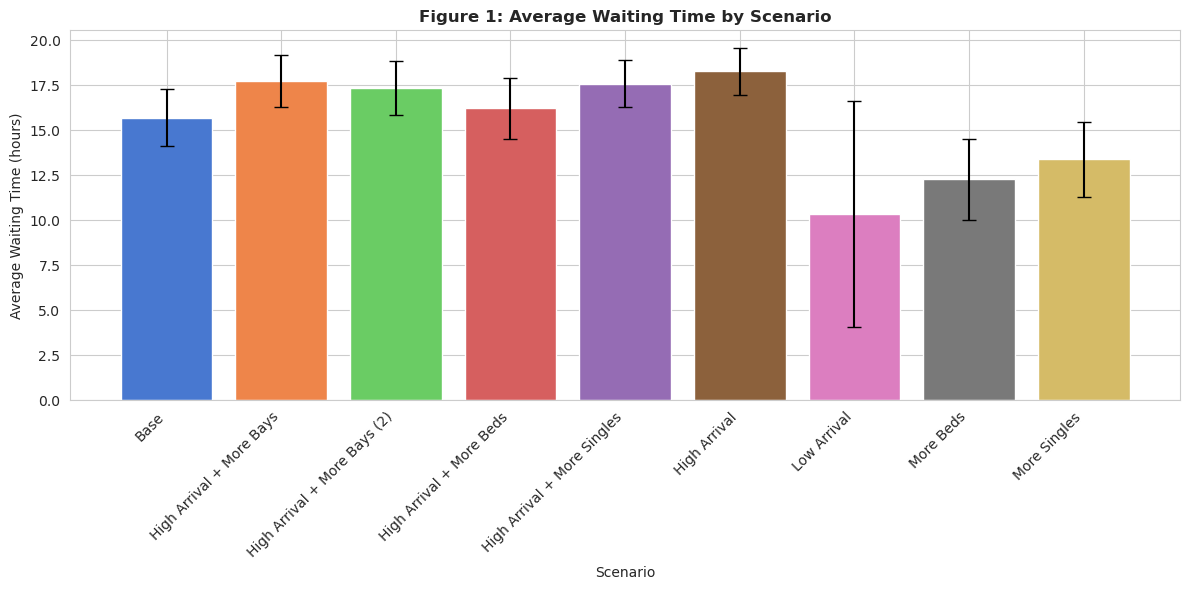

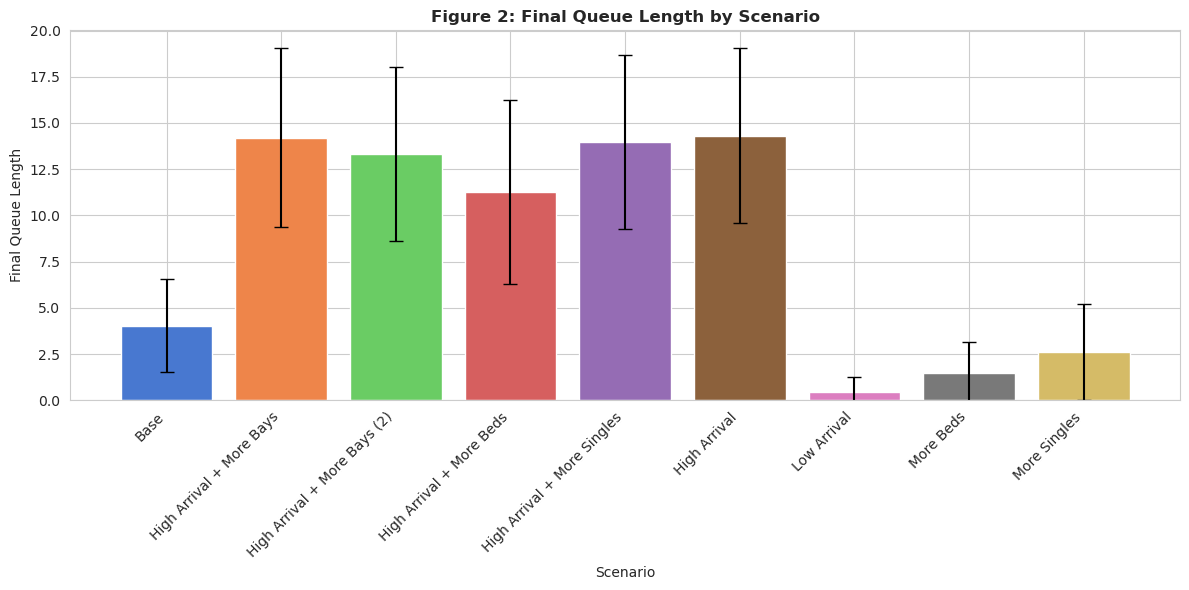

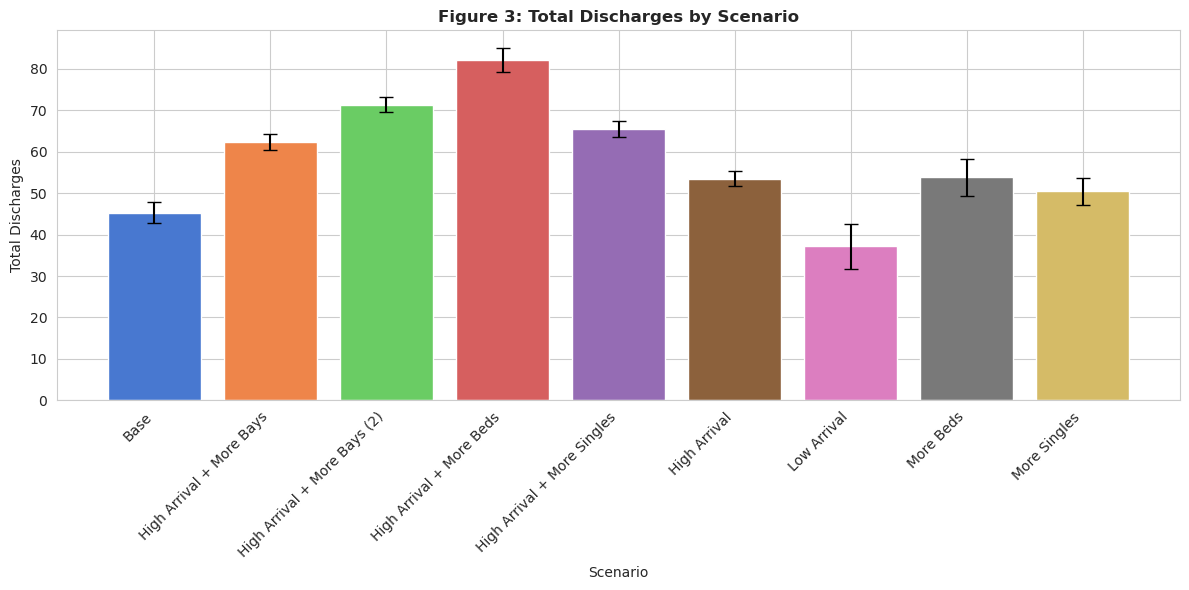

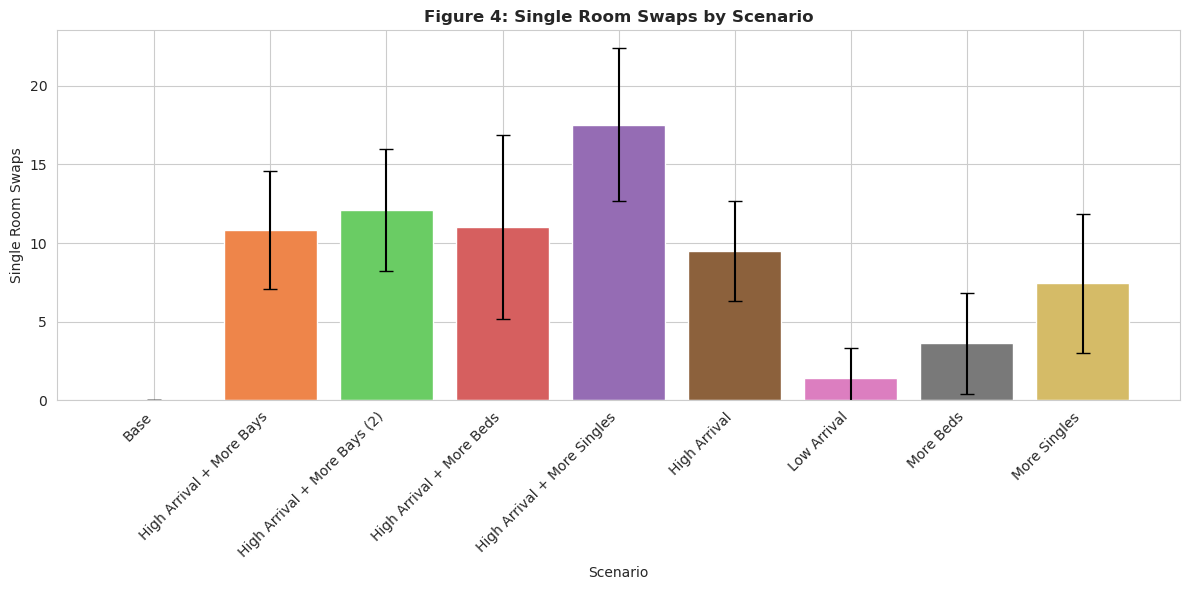

In [1]:
# ==============================================================================
# Section 0: Imports
# ==============================================================================
import simpy  # For discrete-event simulation
import numpy as np  # For random number generation and numerical operations
import matplotlib.pyplot as plt  # For visualizing results
import pandas as pd  # For data manipulation and analysis
from dataclasses import dataclass  # For creating simple data structures
from typing import List, Dict, Optional  # For type hinting

# ==============================================================================
# Section 1: Data Structures and Core Classes
# ==============================================================================

@dataclass
class Patient:
    pid: int              # Unique patient ID
    arrival_time: float   # Time of arrival at the hospital
    gender: str           # Gender of the patient ('male' or 'female')
    group: str            # Group identifier (e.g., "Group1")
    los_hours: float      # Length of stay in hours
    max_wait: float       # Maximum waiting time before leaving
    waiting_time: float = 0.0      # Time spent waiting for a bed
    bed_allocated: bool = False    # Whether the patient has been allocated a bed
    abandon_time: float = float('inf')  # Time this patient will abandon if not admitted sooner

class WardBay:
    def __init__(self, bay_id: int, capacity: int):
        self.bay_id = bay_id
        self.capacity = capacity
        self.current_gender: Optional[str] = None
        self.patients: List[Patient] = []

    def can_accept(self, p: Patient) -> bool:
        if len(self.patients) >= self.capacity:
            return False
        return (self.current_gender is None) or (self.current_gender == p.gender)

    def add_patient(self, p: Patient):
        self.patients.append(p)
        if self.current_gender is None:
            self.current_gender = p.gender

    def remove_patient(self, p: Patient):
        if p in self.patients:
            self.patients.remove(p)
        if len(self.patients) == 0:
            self.current_gender = None

    @property
    def n_occupied(self):
        return len(self.patients)

    @property
    def n_free(self):
        return self.capacity - len(self.patients)

class HospitalWard:
    def __init__(self, env: simpy.Environment, num_bays: int, beds_per_bay: int, num_singles: int):
        self.env = env
        self.bays: List[WardBay] = [WardBay(bay_id=i, capacity=beds_per_bay) for i in range(num_bays)]
        self.single_rooms: List[Optional[Patient]] = [None] * num_singles
        self.wait_queue: List[Patient] = []
        self.wait_times: Dict[int, float] = {}
        self.single_room_swaps: int = 0
        self.total_discharges: int = 0

    def try_allocate(self, p: Patient, allow_shuffle: bool = True) -> bool:
        # 1) Try to place the patient in a bay with the same gender
        same_gender_bays = [bay for bay in self.bays if bay.can_accept(p) and bay.current_gender == p.gender]
        if same_gender_bays:
            bay = max(same_gender_bays, key=lambda b: b.n_occupied / b.capacity)
            bay.add_patient(p)
            p.bed_allocated = True
            return True

        # 2) Try to place the patient in an empty bay
        empty_bays = [bay for bay in self.bays if bay.can_accept(p) and bay.current_gender is None]
        if empty_bays:
            bay = empty_bays[0]
            bay.add_patient(p)
            p.bed_allocated = True
            return True

        # 3) Try to place the patient in a single room
        for i in range(len(self.single_rooms)):
            if self.single_rooms[i] is None:
                self.single_rooms[i] = p
                p.bed_allocated = True
                return True

        # 4) If allowed, shuffle occupant in single room of the opposite gender
        if allow_shuffle:
            for i in range(len(self.single_rooms)):
                occupant = self.single_rooms[i]
                if occupant is not None and occupant.gender != p.gender:
                    occupant.bed_allocated = False
                    if self.try_allocate(occupant, allow_shuffle=False):
                        self.single_rooms[i] = p
                        p.bed_allocated = True
                        self.single_room_swaps += 1
                        return True
                    else:
                        occupant.bed_allocated = True
        return False

# ==============================================================================
# Section 2: Simulation Processes
# ==============================================================================

def patient_generator(env, ward: HospitalWard, group_name: str,
                      mean_iat: float, los_days: float, gender_prob: float,
                      max_wait_hours: float, rng_seed: int = 42):
    rng = np.random.default_rng(rng_seed)
    pid_count = 0

    while True:
        iat = rng.exponential(mean_iat)
        yield env.timeout(iat)

        pid_count += 1
        arrival_time = env.now
        gender = 'female' if rng.random() < gender_prob else 'male'
        los_hours = los_days * 24.0

        patient = Patient(pid=pid_count,
                          arrival_time=arrival_time,
                          gender=gender,
                          group=group_name,
                          los_hours=los_hours,
                          max_wait=max_wait_hours)

        # 10% chance the patient will leave early
        if rng.random() < 0.10:
            early_leave_offset = rng.uniform(0, max_wait_hours)
            patient.abandon_time = arrival_time + early_leave_offset
        else:
            patient.abandon_time = float('inf')

        # (Removed console output for arrivals)
        allocated = ward.try_allocate(patient)
        if allocated:
            env.process(treatment_process(env, ward, patient))
        else:
            patient.waiting_time = env.now
            ward.wait_queue.append(patient)
            env.process(wait_in_queue(env, ward, patient))

def wait_in_queue(env, ward: HospitalWard, p: Patient):
    recheck_interval = 4.0
    start_wait = env.now

    while True:
        yield env.timeout(recheck_interval)

        if p not in ward.wait_queue:
            return

        # If the patient reached personal abandonment time, leave
        if env.now >= p.abandon_time:
            ward.wait_queue.remove(p)
            # (Removed console output)
            return

        # If they've exceeded max_wait, leave
        if (env.now - start_wait) > p.max_wait:
            ward.wait_queue.remove(p)
            # (Removed console output)
            return

        allocated = ward.try_allocate(p)
        if allocated:
            ward.wait_queue.remove(p)
            total_wait = env.now - start_wait
            ward.wait_times[p.pid] = total_wait
            # (Removed console output)
            env.process(treatment_process(env, ward, p))
            return

def treatment_process(env, ward: HospitalWard, p: Patient):
    yield env.timeout(p.los_hours)
    discharge_patient(ward, p, env.now)

def discharge_patient(ward: HospitalWard, p: Patient, current_time: float):
    # Check if the patient is in any bay
    for bay in ward.bays:
        if p in bay.patients:
            bay.remove_patient(p)
            ward.total_discharges += 1
            # (Removed console output)
            return

    # Otherwise, check single rooms
    for i, occupant in enumerate(ward.single_rooms):
        if occupant == p:
            ward.single_rooms[i] = None
            ward.total_discharges += 1
            # (Removed console output)
            return

# ==============================================================================
# Section 3: Simulation and Replication Functions (with Custom Parameters)
# ==============================================================================

def run_simulation(replication_time: float, seed: int,
                   mean_iat: float, los_days: float, gender_prob: float,
                   max_wait_hours: float, num_bays: int, beds_per_bay: int, num_singles: int) -> Dict:
    env = simpy.Environment()
    ward = HospitalWard(env, num_bays=num_bays, beds_per_bay=beds_per_bay, num_singles=num_singles)

    env.process(patient_generator(env, ward, group_name="Group1",
                                  mean_iat=mean_iat,
                                  los_days=los_days,
                                  gender_prob=gender_prob,
                                  max_wait_hours=max_wait_hours,
                                  rng_seed=seed))

    env.run(until=replication_time)

    avg_wait = np.mean(list(ward.wait_times.values())) if ward.wait_times else 0.0
    max_wait = np.max(list(ward.wait_times.values())) if ward.wait_times else 0.0

    metrics = {
        "FinalQueueLength": len(ward.wait_queue),
        "AverageWaitingTime": avg_wait,
        "MaxWaitingTime": max_wait,
        "TotalDischarges": ward.total_discharges,
        "SingleRoomSwaps": ward.single_room_swaps,
        "SimulationTime": replication_time
    }
    return metrics

def run_replications(num_replications: int, replication_time: float,
                     mean_iat: float, los_days: float, gender_prob: float,
                     max_wait_hours: float, num_bays: int, beds_per_bay: int, num_singles: int) -> pd.DataFrame:
    all_metrics = []
    for rep in range(num_replications):
        seed = 1000 + rep
        metrics = run_simulation(replication_time, seed,
                                 mean_iat, los_days, gender_prob,
                                 max_wait_hours, num_bays, beds_per_bay, num_singles)
        metrics["Replication"] = rep + 1
        all_metrics.append(metrics)

    df = pd.DataFrame(all_metrics)
    return df

# ==============================================================================
# Section 4: Running Multiple Scenarios and Visualising Results
# ==============================================================================

def run_scenarios():
    scenarios = [
        {"scenario_id": "Base",        "mean_iat": 4.0, "los_days": 3.0, "num_bays": 5, "beds_per_bay": 3, "num_singles": 0, "max_wait_hours": 36.0},
        {"scenario_id": "HighArrival", "mean_iat": 2.0, "los_days": 3.0, "num_bays": 5, "beds_per_bay": 3, "num_singles": 1, "max_wait_hours": 36.0},
        {"scenario_id": "LowArrival",  "mean_iat": 6.0, "los_days": 3.0, "num_bays": 5, "beds_per_bay": 3, "num_singles": 1, "max_wait_hours": 36.0},
        {"scenario_id": "MoreBeds",    "mean_iat": 4.0, "los_days": 3.0, "num_bays": 6, "beds_per_bay": 3, "num_singles": 1, "max_wait_hours": 36.0},
        {"scenario_id": "MoreSingles", "mean_iat": 4.0, "los_days": 3.0, "num_bays": 5, "beds_per_bay": 3, "num_singles": 2, "max_wait_hours": 36.0},
        {"scenario_id": "HA_M_Beds",   "mean_iat": 2.0, "los_days": 3.0, "num_bays": 5, "beds_per_bay": 5, "num_singles": 1, "max_wait_hours": 36.0},
        {"scenario_id": "HA_M_Bays",   "mean_iat": 2.0, "los_days": 3.0, "num_bays": 6, "beds_per_bay": 3, "num_singles": 1, "max_wait_hours": 36.0},
        {"scenario_id": "HA_M_Bays2",  "mean_iat": 2.0, "los_days": 3.0, "num_bays": 7, "beds_per_bay": 3, "num_singles": 1, "max_wait_hours": 36.0},
        {"scenario_id": "HA_M_Singles","mean_iat": 2.0, "los_days": 3.0, "num_bays": 5, "beds_per_bay": 3, "num_singles": 5, "max_wait_hours": 36.0}
    ]

    replication_time = 300
    num_replications = 30

    scenario_results = []
    for scen in scenarios:
        # (Removed scenario console output)
        df = run_replications(num_replications, replication_time,
                              mean_iat=scen["mean_iat"],
                              los_days=scen["los_days"],
                              gender_prob=0.66,
                              max_wait_hours=scen["max_wait_hours"],
                              num_bays=scen["num_bays"],
                              beds_per_bay=scen["beds_per_bay"],
                              num_singles=scen["num_singles"])
        df["Scenario"] = scen["scenario_id"]
        scenario_results.append(df)

    all_results = pd.concat(scenario_results, ignore_index=True)
    return all_results

def visualize_scenario_results(df: pd.DataFrame):
    """
    Generates visualizations comparing the results of different scenarios.
    Uses a white background with gridlines and a muted, professional color palette.
    Ensures all y-axes start at 0 and plot titles are bold.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    # Set Seaborn style to whitegrid for a clean, white background with gridlines.
    sns.set_style("whitegrid")

    # Define friendlier labels for each scenario.
    scenario_rename = {
        "Base":         "Base",
        "HighArrival":  "High Arrival",
        "LowArrival":   "Low Arrival",
        "MoreBeds":     "More Beds",
        "MoreSingles":  "More Singles",
        "HA_M_Beds":    "High Arrival + More Beds",
        "HA_M_Bays":    "High Arrival + More Bays",
        "HA_M_Bays2":   "High Arrival + More Bays (2)",
        "HA_M_Singles": "High Arrival + More Singles"
    }

    # Aggregate and compute summary statistics.
    summary = df.groupby("Scenario").agg({
        "AverageWaitingTime": ["mean", "std"],
        "FinalQueueLength":   ["mean", "std"],
        "TotalDischarges":    ["mean", "std"],
        "SingleRoomSwaps":    ["mean", "std"]
    })
    summary.columns = ["_".join(col).strip() for col in summary.columns.values]
    summary.reset_index(inplace=True)

    # Rename the scenario labels to friendlier names.
    summary["Scenario"] = summary["Scenario"].map(scenario_rename)

    # Optional: Print summary statistics.
    print("\n--- Summary Statistics per Scenario ---")
    print(summary.to_string(index=False))

    # Create a professional muted color palette.
    unique_scenarios = summary["Scenario"].unique()
    palette = sns.color_palette("muted", n_colors=len(unique_scenarios))
    color_map = dict(zip(unique_scenarios, palette))

    def get_colors_for_scenarios(scenario_col):
        return [color_map[s] for s in scenario_col]

    # -- Figure 1: Average Waiting Time --
    plt.figure(figsize=(12, 6), facecolor='white')
    plt.bar(summary["Scenario"], summary["AverageWaitingTime_mean"],
            yerr=summary["AverageWaitingTime_std"], capsize=5,
            color=get_colors_for_scenarios(summary["Scenario"]))
    plt.xlabel("Scenario")
    plt.ylabel("Average Waiting Time (hours)")
    plt.title("Figure 1: Average Waiting Time by Scenario", fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(bottom=0)
    plt.tight_layout()
    plt.show()

    # -- Figure 2: Final Queue Length --
    plt.figure(figsize=(12, 6), facecolor='white')
    plt.bar(summary["Scenario"], summary["FinalQueueLength_mean"],
            yerr=summary["FinalQueueLength_std"], capsize=5,
            color=get_colors_for_scenarios(summary["Scenario"]))
    plt.xlabel("Scenario")
    plt.ylabel("Final Queue Length")
    plt.title("Figure 2: Final Queue Length by Scenario", fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(bottom=0)
    plt.tight_layout()
    plt.show()

    # -- Figure 3: Total Discharges --
    plt.figure(figsize=(12, 6), facecolor='white')
    plt.bar(summary["Scenario"], summary["TotalDischarges_mean"],
            yerr=summary["TotalDischarges_std"], capsize=5,
            color=get_colors_for_scenarios(summary["Scenario"]))
    plt.xlabel("Scenario")
    plt.ylabel("Total Discharges")
    plt.title("Figure 3: Total Discharges by Scenario", fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(bottom=0)
    plt.tight_layout()
    plt.show()

    # -- Figure 4: Single Room Swaps --
    plt.figure(figsize=(12, 6), facecolor='white')
    plt.bar(summary["Scenario"], summary["SingleRoomSwaps_mean"],
            yerr=summary["SingleRoomSwaps_std"], capsize=5,
            color=get_colors_for_scenarios(summary["Scenario"]))
    plt.xlabel("Scenario")
    plt.ylabel("Single Room Swaps")
    plt.title("Figure 4: Single Room Swaps by Scenario", fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(bottom=0)
    plt.tight_layout()
    plt.show()
    
# ==============================================================================
# Section 5: Main Execution
# ==============================================================================

def main():
    """
    Main function to execute the simulation workflow without printing console
    output, displaying only plots of final results.
    """
    results_df = run_scenarios()

    # All print statements removed or commented out; we only plot now:
    visualize_scenario_results(results_df)

    # Save results to CSV (if desired); can be commented out if not needed:
    results_df.to_csv("simulation_results.csv", index=False)

if __name__ == '__main__':
    main()